<h1 style="font-family: Cambria; text-align: center;">
Test
</h1>

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h2 style="font-family: Cambria; text-align: center;">
Task 1: Load Trained Model and Predict
</h2>

In [2]:
sys.path.append(os.path.abspath('../src'))
from dataset import FlowDataset
from models import HybridUNet

In [3]:
SEED = 42
np.random.seed(SEED)

In [4]:
def load_model_and_predict(config, sample_index=None):
    """
    Loads the model to perform inference.
    
    Args:
        config (dict): Configuration dictionary containing data paths and model parameters.
        sample_index (int, optional): Specific dataset index to verify. If None, selects randomly.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Initialize Dataset (Validation Mode).
    print(f"Loading dataset: {config['data_path']} ...")
    dataset = FlowDataset(
        file_path=config["data_path"], 
        mode="val",
    )
    
    # 2. Select a sample.
    if sample_index is None:
        sample_index = np.random.randint(len(dataset))
    
    print(f"Fetching sample ID: {sample_index} ...")
    inputs, targets, dt = dataset[sample_index]

    # 3. Add Batch dimension (B, C, D, H, W) and move to GPU.
    inputs = inputs.unsqueeze(0).to(device)
    targets = targets.unsqueeze(0).to(device)
    dt = dt.unsqueeze(0).to(device)

    # 4. Load Model.
    print("Loading model...")
    model = HybridUNet( ).to(device)
    
    checkpoint_path = os.path.join(config["checkpoint_dir"], "best_model.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print(f"Successfully loaded weights: {checkpoint_path}")
    else:
        print(f"Warning: Weights file {checkpoint_path} not found. Using random initialization for testing.")

    # 5. Inference.
    model.eval()
    with torch.no_grad():
        preds = model(inputs, dt)

    return targets.squeeze(0).cpu().numpy(), preds.squeeze(0).cpu().numpy()

<h2 style="font-family: Cambria; text-align: center;">
Task 2: Visualization of Residuals and Flowfields
</h2>

In [5]:
CONFIG = {
    "data_path": "/data1/wangteng/processed/channel_flow.hdf5",
    "checkpoint_dir": "/home/wangteng/Projects/checkpoints",
}

<div style="font-family: Cambria;">
Function for visualizing residuals.
</div>

In [6]:
def visualize_residuals(target, prediction, slice_idx=16):
    """
    Visualizes velocity magnitude and residuals on a specific slice.
    
    Args:
        target      (np.ndarray): Ground truth with shape [C, D, H, W].
        prediction  (np.ndarray): Model prediction with shape [C, D, H, W]
        slice_idx   (int)       : The Z-axis index of the slice to visualize.
    """
    print("Visualizing residuals...")
    
    target_mag = np.sqrt(np.sum(target[ : 3] ** 2, axis=0))
    pred_mag = np.sqrt(np.sum(prediction[ : 3] ** 2, axis=0))
    residual = np.abs(target_mag - pred_mag)
    
    # Extract middle slice (Z-axis).
    t_slice = target_mag[slice_idx, :, :]
    p_slice = pred_mag[slice_idx, :, :]
    r_slice = residual[slice_idx, :, :]
    
    # Plotting.
    _, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    im1 = axes[0].imshow(t_slice, cmap='jet')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(p_slice, cmap='jet')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(r_slice, cmap='inferno')
    axes[2].set_title('Residual')
    plt.colorbar(im3, ax=axes[2])
    
    plt.suptitle(f'Residual Analysis at Slice Z={slice_idx}')
    plt.show()

<div style="font-family: Cambria;">
Function for visualizing slices of the flowfield.
</div>

In [7]:
def visualize_flow_vectors(target, prediction, slice_idx=16):
    """
    Visualizes flow field vectors using Quiver plots.
    
    Args:
        target      (np.ndarray): Ground truth with shape [C, D, H, W].
        prediction  (np.ndarray): Model prediction with shape [C, D, H, W].
    """
    print("Visualizing flow field vectors...")
    
    # Extract u, v components for 2D plane plotting.
    u_pred = prediction[0, slice_idx, :, :]
    v_pred = prediction[1, slice_idx, :, :]
    
    u_true = target[0, slice_idx, :, :]
    v_true = target[1, slice_idx, :, :]
    
    # Downsample to avoid overly dense arrows (step=4 means take 1 arrow every 4 pixels).
    step = 4
    Y, X = np.mgrid[0:u_pred.shape[0]:step, 0:u_pred.shape[1]:step]
    
    u_pred_s = u_pred[::step, ::step]
    v_pred_s = v_pred[::step, ::step]
    u_true_s = u_true[::step, ::step]
    v_true_s = v_true[::step, ::step]
    
    _, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Ground Truth Flow Field.
    axes[0].quiver(X, Y, u_true_s, v_true_s, color='g', scale=20)
    axes[0].set_title('Ground Truth Flow Field (Vectors)')
    axes[0].invert_yaxis()

    # Predicted Flow Field.
    axes[1].quiver(X, Y, u_pred_s, v_pred_s, color='b', scale=20)
    axes[1].set_title('Predicted Flow Field (Vectors)')
    axes[1].invert_yaxis()
    
    plt.show()

<div style="font-family: Cambria;">
Execution.
</div>

Using device: cuda
Loading dataset: /data1/wangteng/processed/channel_flow.hdf5 ...
[VAL] Assigned 4 time frames.
[VAL] Total samples generated: 23040
Fetching sample ID: 0 ...
Loading model...


/tmp/ipykernel_2136309/932881209.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Successfully loaded weights: /home/wangteng/Projects/checkpoints/best_model.pth
Visualizing residuals...


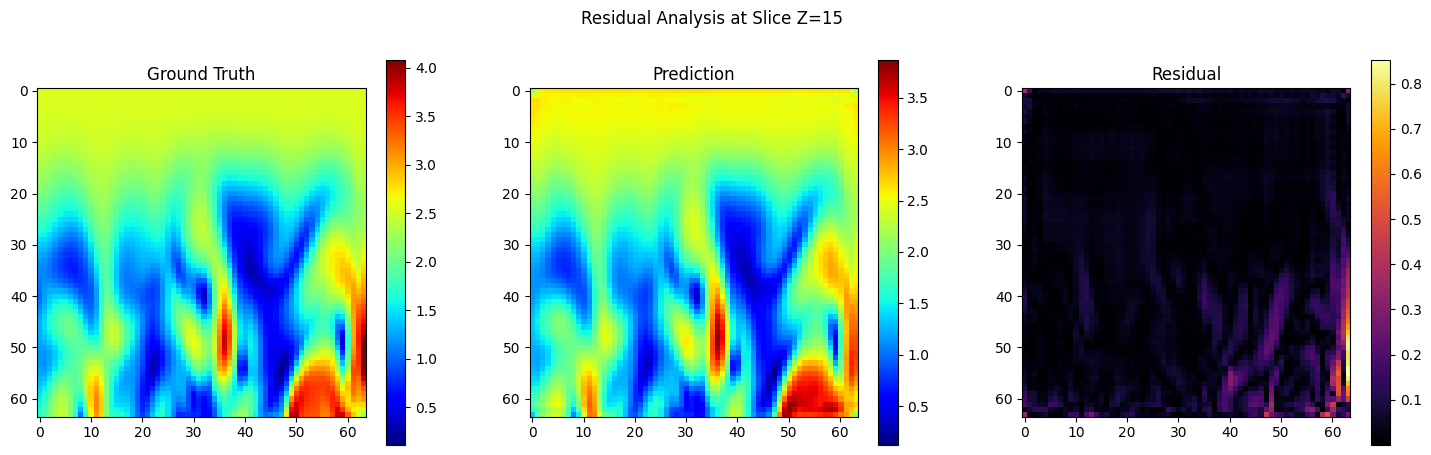

Visualizing flow field vectors...


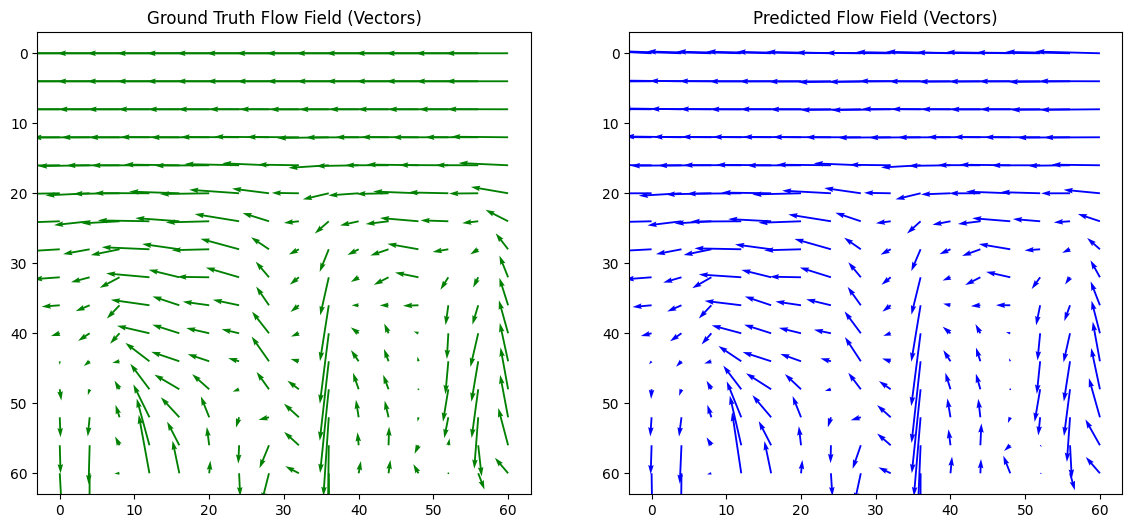

In [8]:
try:
    # Get Data and Prediction.
    target_flow, pred_flow = load_model_and_predict(CONFIG, sample_index=0)
        
    # 3. Visualize Residuals (Select middle slice Z=15).
    visualize_residuals(target_flow, pred_flow, slice_idx=15)
        
    # 4. Visualize Flow Vectors.
    visualize_flow_vectors(target_flow, pred_flow, slice_idx=15)
        
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"An error occurred: {e}")

<h2 style="font-family: Cambria; text-align: center;">
Task 3: Curves of Losses and Learning-Rate
</h2>

In [9]:
def visualize_training_log(file_path):
    """
    Plots the training loss, validation loss, and learning rate curves.
    """
    try:
        df = pd.read_csv(file_path)

    except FileNotFoundError:
        print(f"Error: File not found. Please check the path: {file_path}")
        return
    
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
        return
    
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return

    required_columns = ['Epoch', 'Train_Loss', 'Val_Loss', 'Learning_Rate']
    if not all(col in df.columns for col in required_columns):
        print("Error: CSV column names do not match. Please confirm the file contains: Epoch,Train_Loss,Val_Loss,Learning_Rate")
        print(f"Columns in the file are: {df.columns.tolist()}")
        return

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # ========== Loss Curve ==========
    loss_color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=loss_color)
    
    # Training Loss.
    ax1.plot(df['Epoch'], df['Train_Loss'], label='Train Loss', color='blue', linestyle='-')

    # Validation Loss.
    ax1.plot(df['Epoch'], df['Val_Loss'], label='Validation Loss', color='red', linestyle='--')
    
    ax1.tick_params(axis='y', labelcolor=loss_color)
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':', alpha=0.6)

    # ========== Learning Rate ==========
    ax2 = ax1.twinx()
    lr_color = 'tab:green'
    ax2.set_ylabel('Learning Rate', color=lr_color)
    ax2.plot(df['Epoch'], df['Learning_Rate'], label='Learning Rate', color=lr_color, linestyle=':', alpha=0.6)
    ax2.tick_params(axis='y', labelcolor=lr_color)
    ax2.set_yscale('log') 

    plt.title('Training Performance', fontsize=16)
    fig.tight_layout() 
    plt.show()


<div style="font-family: Cambria;">
Set the path to your training log CSV file.
</div>

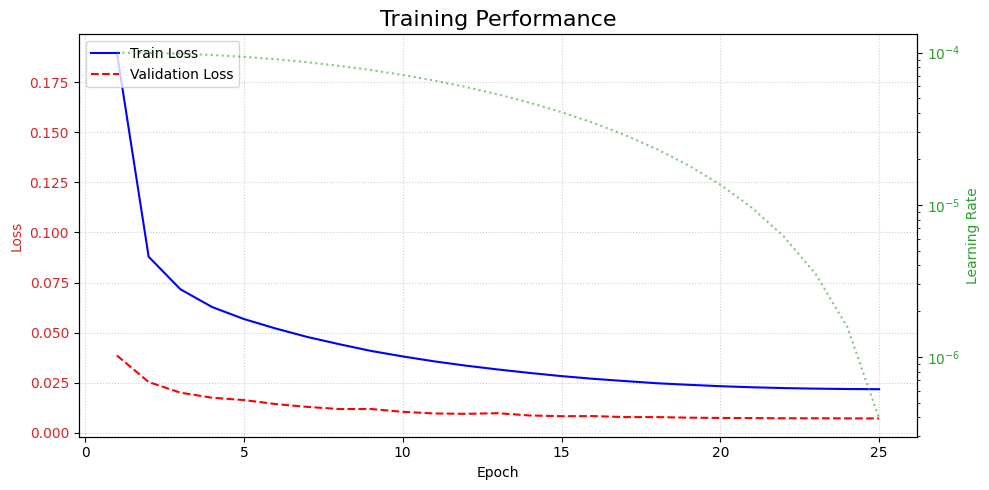

In [10]:
LOG_CSV_PATH = "/home/wangteng/Projects/logs/training_log.csv"

visualize_training_log(LOG_CSV_PATH)